In [1]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
import warnings
import sys
sys.path.insert(0, '..')
from src.metric.metric import calculate_metric

warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Classificator

In [2]:
from detoxify import Detoxify
classificator = Detoxify('unbiased')
results = classificator.predict(['example text 1','G...! What the fuck?'])
results['toxicity']

[0.0004102117964066565, 0.974835991859436]

Paraphraser model

In [3]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
model_name = 'tuner007/pegasus_paraphrase'

tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

def get_response(input_text, num_return_sequences=5,num_beams=5):
  batch = tokenizer(input_text,truncation=True,padding='longest', return_tensors="pt").to(device)
  translated = model.generate(**batch, num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text


In [4]:
def paraphraser(batch_sentence : list, batch_size: int, num_beams=5, num_return_sequences=5) -> list:
    paraphrased_variants = get_response(batch_sentence, num_beams=num_beams, num_return_sequences=num_return_sequences)
    toxicity = classificator.predict(paraphrased_variants)['toxicity']
    
    best_paraphrased = []

    for batch_start in range(batch_size):
        left, right = batch_start * num_return_sequences,  (batch_start + 1) * num_return_sequences

        ind = np.argmin(toxicity[left: right])
        best_paraphrased.append(paraphrased_variants[left : right][ind])

    return best_paraphrased


In [5]:
from src.data.make_dataset import FilteredDataset
from torch.utils.data import DataLoader

batch_size = 16
test_dataset = FilteredDataset(test=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In previous we classified and paraphrased each word in sentence, now the model, since it seq2seq, it allows us to paraphrased any number of words in sentence, so let’s introduce hyperparameter n - number of words in one token

In [6]:
#n-hyperparameter
#n-word tokenizer
from typing import Union

def n_word_tokenizer(sentences: Union[str, list], n=2):
    
    #add batch
    if isinstance(sentences, str):
        sentences = [sentences]

    batch = []
    for sentence in sentences:
        splitted = sentence.split()
        slices = [splitted[i * n: i * n + n] for i in range((len(splitted)  + n - 1)// n)]
        n_sentence = [' '.join(part) for part in slices]
        batch.append(n_sentence)
    return batch

In [7]:
n_word_tokenizer('n_word tokenizer split the sentence into list, where len of each element is <= n', n=2)

[['n_word tokenizer',
  'split the',
  'sentence into',
  'list, where',
  'len of',
  'each element',
  'is <=',
  'n']]

In [11]:
#grid search of n
#let's take 1000 examples due to lack of perfomance and trying to figure out the best n
from torch.utils.data import Subset

N_samples = 100
num_return_sequences = 2
batch_size = 4
subset_dataset = Subset(test_dataset, np.arange(N_samples))
subset_loader = DataLoader(subset_dataset, batch_size=batch_size)


Since the number of words in average is 10, so let's grid search n until the half of sentence and take to consideration also the whole sentence

In [12]:
max_number_of_words = 300
n_params = [2, 3, 4, 5, max_number_of_words]
dict_metrics = {'ACC': [], 'SIM': [], 'FL': [], 'J': [], 'BLUE':[]}

for n in tqdm(n_params):
    outputs = []
    target = []

    for batch, y_true in subset_loader:
        tokenized = n_word_tokenizer(batch, n)
        offset = [len(x) for x in tokenized]
        offset = [sum(offset[:i]) for i in range(len(offset) + 1)]
        tokenized = np.concatenate(tokenized)
        paraphrased = paraphraser(list(tokenized), len(tokenized))
        collected_batch = [' '.join(paraphrased[offset[i]: offset[i + 1]]) for i in range(len(offset) - 1)]
        
        outputs += collected_batch
        target += y_true
    
    metrics = calculate_metric(target, outputs)
    for key in metrics:
        dict_metrics[key].append(metrics[key])



  0%|          | 0/5 [00:00<?, ?it/s]

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 18.34it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 153.61it/s]


Calculating CoLA acceptability stats


 20%|██        | 1/5 [00:50<03:21, 50.42s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.7700|0.5691|0.4675|0.2146|0.2616|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 131.00it/s]


Calculating CoLA acceptability stats


 40%|████      | 2/5 [01:25<02:03, 41.22s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.8400|0.6178|0.6439|0.3445|0.3379|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 14.35it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 132.73it/s]


Calculating CoLA acceptability stats


 60%|██████    | 3/5 [02:00<01:16, 38.48s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.8200|0.6199|0.6588|0.3406|0.3561|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 23.01it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 163.63it/s]


Calculating CoLA acceptability stats


 80%|████████  | 4/5 [02:35<00:37, 37.22s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.8300|0.6080|0.7444|0.3779|0.3768|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 169.54it/s]


Calculating CoLA acceptability stats


100%|██████████| 5/5 [03:06<00:00, 37.32s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.8000|0.6742|0.9407|0.5072|0.4265|



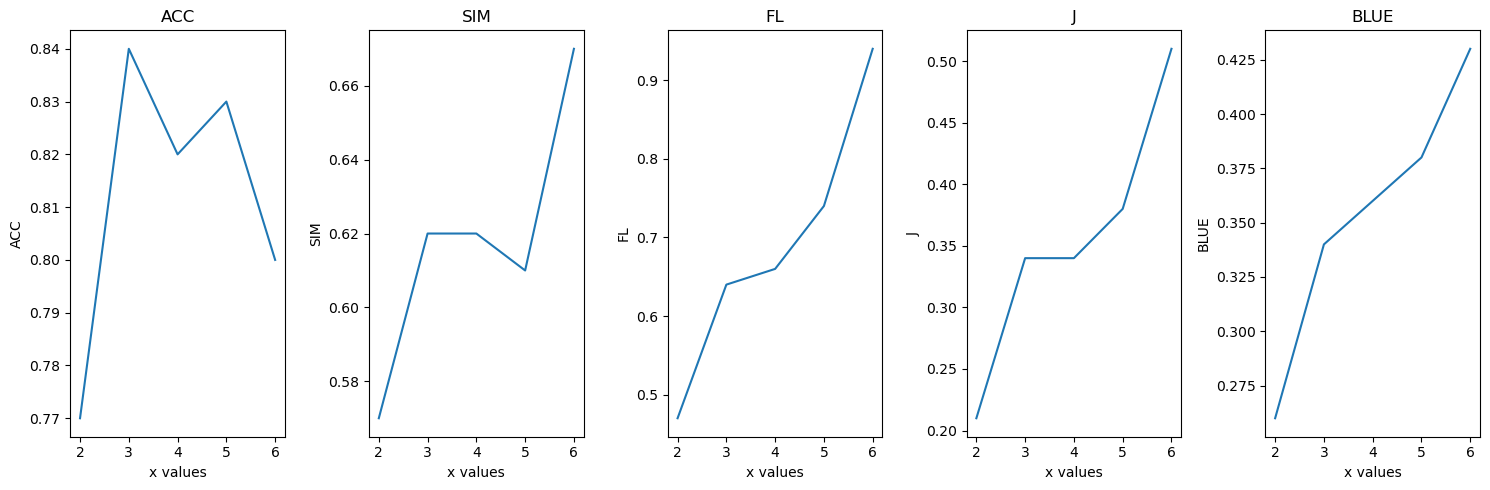

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(dict_metrics), figsize=(15, 5))
x = [2, 3, 4, 5, 6]
#6 - the whole sentence
for i, (metric, values) in enumerate(dict_metrics.items()):
    axs[i].plot(x, np.round(values, 2))
    axs[i].set_title(metric)
    axs[i].set_xlabel('x values')
    axs[i].set_ylabel(metric)

plt.tight_layout()
plt.show()